In [1]:
# Load required library packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline

color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') 

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))

PREDICT_HOUR = 4

fare_data.csv
nb-analysis.ipynb
ny-predict-taxi-demand-Boosted-Decision-tree.ipynb
ny-predict-taxi-demand-Linear-Regression-3-lag.ipynb
ny-predict-taxi-demand-Linear-Regression-full.ipynb
ny-predict-taxi-demand-Random-Forest.ipynb
ny-predict-taxi-demand-baseline.ipynb
ny-predict-taxi-demand.ipynb
trip_data.csv



In [2]:
# Load trip data csv
df_trip = pd.read_csv('trip_data.csv',
                      parse_dates=['pickup_datetime', 
                                        'dropoff_datetime'])
print(df_trip.shape)
df_trip.head()
print(df_trip.vendor_id.unique())

(13059961, 14)
['CMT' 'VTS']


In [ ]:
# clean data
df_trip_indexed = df_trip.reset_index()

# Remove null values
df_trip_indexed = df_trip_indexed.dropna()

# Remove trips with zero passengers
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.passenger_count < 0].index)

# Remove trips with time less than zero
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs < 0].index)

# Remove trips with time greater than 10 hours
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs > 36000].index)

In [3]:
# Generate features based on pickup hour
df_trip_indexed = df_trip.reset_index()
df_trip_indexed['trip_date'] = df_trip_indexed['pickup_datetime'].dt.date
df_trip_indexed['trip_hour'] = df_trip_indexed['pickup_datetime'].dt.hour
#df = pd.DataFrame(df_trip_indexed.groupby(['pickup_datetime.dt.hour']).count()['index'])
df_trip_indexed.head()


,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_date,trip_hour
0,0,001DFAC01BC0A32F48C3769DD1414778,5A677E8D42137D0006944AF0E4D4488C,CMT,1,N,2013-01-19 12:37:55,2013-01-19 12:51:26,3,810,3.1,-73.988869,40.736645,-73.957756,40.768227,2013-01-19,12
1,1,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,1,N,2013-01-18 15:16:11,2013-01-18 15:32:51,1,1000,2.6,-73.967781,40.762726,-73.976303,40.788666,2013-01-18,15
2,2,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,5,N,2013-01-18 15:34:56,2013-01-18 16:21:18,1,2782,18.3,-73.974121,40.791367,-74.184647,40.692551,2013-01-18,15
3,3,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,5,N,2013-01-18 23:06:21,2013-01-18 23:26:43,1,1221,5.1,-73.987343,40.738934,-74.035683,40.716774,2013-01-18,23
4,4,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,1,N,2013-01-18 22:18:20,2013-01-18 22:32:08,1,828,3.4,-73.956642,40.771252,-73.955116,40.741486,2013-01-18,22


In [4]:
# Generate trips per hour 
temp = df_trip_indexed.drop(['medallion','hack_license','vendor_id', 'pickup_datetime' ,'rate_code', 'store_and_fwd_flag', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=False)
df_trips_ph = pd.DataFrame(temp.groupby(['trip_date', 'trip_hour']).count().reset_index())
df_trips_ph.columns = ['pickup_date', 'pickup_hour', 'trips']
df_trips_ph.head()

,pickup_date,pickup_hour,trips
0,2013-01-01,0,2264
1,2013-01-01,1,2517
2,2013-01-01,2,2276
3,2013-01-01,3,1988
4,2013-01-01,4,1459


In [5]:
#df_trips_ph['p_datetime'] =  df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['pickup_hour'].astype(str)
#df_trips_ph.head()

df_trips_ph['time'] = df_trips_ph['pickup_hour'].apply(lambda x: "0{0}:00:00".format(x))
df_trips_ph['pickup_dt'] = pd.to_datetime(df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['time'])
df_trips_ph = df_trips_ph.drop(['time'], axis=1, inplace=False)

df_trips_ph['target_hour'] = (df_trips_ph["pickup_hour"] + PREDICT_HOUR)%24
df_trips_ph.head()


,pickup_date,pickup_hour,trips,pickup_dt,target_hour
0,2013-01-01,0,2264,2013-01-01 00:00:00,4
1,2013-01-01,1,2517,2013-01-01 01:00:00,5
2,2013-01-01,2,2276,2013-01-01 02:00:00,6
3,2013-01-01,3,1988,2013-01-01 03:00:00,7
4,2013-01-01,4,1459,2013-01-01 04:00:00,8


In [6]:
df_trips_ph['target_dt'] = df_trips_ph.pickup_dt + pd.to_timedelta(PREDICT_HOUR, unit='h')
df_trips_ph.head()

,pickup_date,pickup_hour,trips,pickup_dt,target_hour,target_dt
0,2013-01-01,0,2264,2013-01-01 00:00:00,4,2013-01-01 04:00:00
1,2013-01-01,1,2517,2013-01-01 01:00:00,5,2013-01-01 05:00:00
2,2013-01-01,2,2276,2013-01-01 02:00:00,6,2013-01-01 06:00:00
3,2013-01-01,3,1988,2013-01-01 03:00:00,7,2013-01-01 07:00:00
4,2013-01-01,4,1459,2013-01-01 04:00:00,8,2013-01-01 08:00:00


In [7]:
# Gerenate target trips to be predicted
temp = df_trips_ph
df_join = pd.merge(temp, df_trips_ph, left_on='target_dt', right_on='pickup_dt', how='inner')

#df_join.head(20)
result = df_join.drop([ 'pickup_date_y', 'pickup_hour_y','target_hour_y' , 'target_dt_y', 'pickup_dt_y'], axis=1, inplace=False)
result.columns = ['pickup_date', 'pickup_hour', 'pickup_trips','pickup_dt', 'target_hour', 'target_dt', 'target_trips']
result['target_day'] = result['target_dt'].dt.day
result = result.drop([ 'pickup_date', 'pickup_hour','target_dt'], axis=1, inplace=False)
result = result.reset_index()
result.head(10)


,index,pickup_trips,pickup_dt,target_hour,target_trips,target_day
0,0,2264,2013-01-01 00:00:00,4,1459,1
1,1,2517,2013-01-01 01:00:00,5,866,1
2,2,2276,2013-01-01 02:00:00,6,682,1
3,3,1988,2013-01-01 03:00:00,7,523,1
4,4,1459,2013-01-01 04:00:00,8,414,1
5,5,866,2013-01-01 05:00:00,9,540,1
6,6,682,2013-01-01 06:00:00,10,801,1
7,7,523,2013-01-01 07:00:00,11,1149,1
8,8,414,2013-01-01 08:00:00,12,1435,1
9,9,540,2013-01-01 09:00:00,13,1507,1


In [8]:
# Add lag features to capture sesonality in data
result['day_lag_0'] = result.groupby(['target_day'])['pickup_trips'].shift(0)
result['day_lag_1'] = result.groupby(['target_day'])['pickup_trips'].shift(1)
result['day_lag_2'] = result.groupby(['target_day'])['pickup_trips'].shift(2)
result['day_lag_3'] = result.groupby(['target_day'])['pickup_trips'].shift(3)
result['day_lag_4'] = result.groupby(['target_day'])['pickup_trips'].shift(4)
result['day_lag_5'] = result.groupby(['target_day'])['pickup_trips'].shift(5)
result['day_lag_6'] = result.groupby(['target_day'])['pickup_trips'].shift(6)

result['hour_lag_0'] = result.groupby(['target_hour'])['pickup_trips'].shift(0)
result['hour_lag_1'] = result.groupby(['target_hour'])['pickup_trips'].shift(1)
result['hour_lag_2'] = result.groupby(['target_hour'])['pickup_trips'].shift(2)
result['hour_lag_3'] = result.groupby(['target_hour'])['pickup_trips'].shift(3)
result['hour_lag_4'] = result.groupby(['target_hour'])['pickup_trips'].shift(4)
result['hour_lag_5'] = result.groupby(['target_hour'])['pickup_trips'].shift(5)
result['hour_lag_6'] = result.groupby(['target_hour'])['pickup_trips'].shift(6)
result.head()

,index,pickup_trips,pickup_dt,target_hour,target_trips,target_day,day_lag_0,day_lag_1,day_lag_2,day_lag_3,day_lag_4,day_lag_5,day_lag_6,hour_lag_0,hour_lag_1,hour_lag_2,hour_lag_3,hour_lag_4,hour_lag_5,hour_lag_6
0,0,2264,2013-01-01 00:00:00,4,1459,1,2264,NaN,NaN,NaN,NaN,NaN,NaN,2264,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2517,2013-01-01 01:00:00,5,866,1,2517,2264.0,NaN,NaN,NaN,NaN,NaN,2517,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2276,2013-01-01 02:00:00,6,682,1,2276,2517.0,2264.0,NaN,NaN,NaN,NaN,2276,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1988,2013-01-01 03:00:00,7,523,1,1988,2276.0,2517.0,2264.0,NaN,NaN,NaN,1988,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1459,2013-01-01 04:00:00,8,414,1,1459,1988.0,2276.0,2517.0,2264.0,NaN,NaN,1459,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train = result.drop(['pickup_dt'], axis=1, inplace=False)
train.columns

Index(['index', 'pickup_trips', 'target_hour', 'target_trips', 'target_day',
       'day_lag_0', 'day_lag_1', 'day_lag_2', 'day_lag_3', 'day_lag_4',
       'day_lag_5', 'day_lag_6', 'hour_lag_0', 'hour_lag_1', 'hour_lag_2',
       'hour_lag_3', 'hour_lag_4', 'hour_lag_5', 'hour_lag_6'],
      dtype='object')

In [10]:
train.head()

,index,pickup_trips,target_hour,target_trips,target_day,day_lag_0,day_lag_1,day_lag_2,day_lag_3,day_lag_4,day_lag_5,day_lag_6,hour_lag_0,hour_lag_1,hour_lag_2,hour_lag_3,hour_lag_4,hour_lag_5,hour_lag_6
0,0,2264,4,1459,1,2264,NaN,NaN,NaN,NaN,NaN,NaN,2264,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2517,5,866,1,2517,2264.0,NaN,NaN,NaN,NaN,NaN,2517,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2276,6,682,1,2276,2517.0,2264.0,NaN,NaN,NaN,NaN,2276,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1988,7,523,1,1988,2276.0,2517.0,2264.0,NaN,NaN,NaN,1988,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1459,8,414,1,1459,1988.0,2276.0,2517.0,2264.0,NaN,NaN,1459,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train = train.dropna(how='any') 
import random
temp = train
X = temp.drop(['target_trips', 'index'], axis=1, inplace=False)
Y = train['target_trips']
Y.head()

# Prepare train and test data
import scipy as sp
rows = random.sample(set(temp.index), int(len(temp)*.80))
x_train, y_train = X.ix[rows],Y.ix[rows]
x_test,y_test = X.drop(rows),Y.drop(rows)

In [19]:
# Run random forest regressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor

regr_rf = RandomForestRegressor(max_depth=6, random_state=2)
clf = regr_rf.fit(x_train, y_train)

In [24]:
mse = mean_squared_error(y_train, clf.predict(x_train))
r2 = r2_score(y_train, clf.predict(x_train))

print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

MSE: 47595.8650
R2: 0.8907


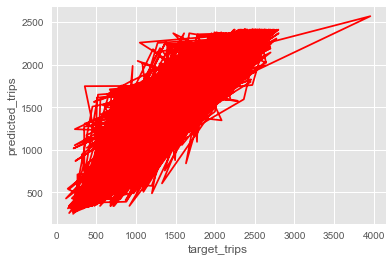

In [25]:
x = y_train
y = clf.predict(x_train)
plt.plot(x, y, 'r-')
plt.xlabel('target_trips')
plt.ylabel('predicted_trips')
plt.show()

In [26]:
mse = mean_squared_error(y_test, clf.predict(x_test))
r2 = r2_score(y_test, clf.predict(x_test))

print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

MSE: 55304.8049
R2: 0.8684


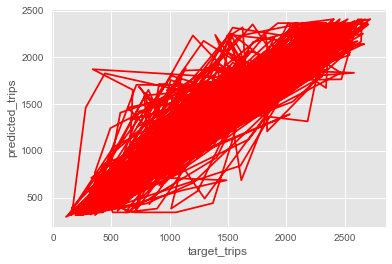

In [27]:
x = y_test
y = clf.predict(x_test)
plt.plot(x, y, 'r-')
plt.xlabel('target_trips')
plt.ylabel('predicted_trips')
plt.show()

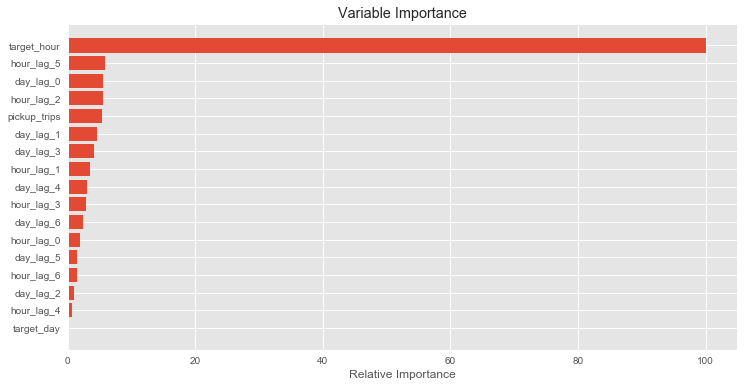

In [23]:
# When doing data mining as important as finding a good model is being able to
# interpret it, because based on that analysis and interpretation preemptive
# actions can be performed. Although base trees are easily interpretable when
# you are adding several of those trees interpretation is more difficult. You
# usually rely on some measures of the predictive power of each feature. Let's
# plot feature importance in predicting the House Value.

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

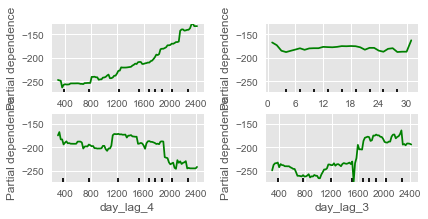

In [17]:
# Once variable importance has been identified we could try to investigate how
# those variables interact between them. For instance, we can plot the
# dependence of the target variable with another variable has been averaged over
# the values of the other variables not being taken into consideration. Some
# variables present a clear monotonic dependence with the target value, while
# others seem not very related to the target variable even when they ranked high
# in the previous plot. This could be signaling an interaction between variables
# that could be further studied. 

from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, axs = plot_partial_dependence(clf, x_train, 
                                   features=[3,2,7,6],
                                   feature_names=x_train.columns,
                                   n_cols=2)

fig.show()